## Spiral Wave Initiation

### Temporal block

Running AlievPanfilov2D: 100%|█████████▉| 10398/10400 [00:02<00:00, 4158.74it/s]


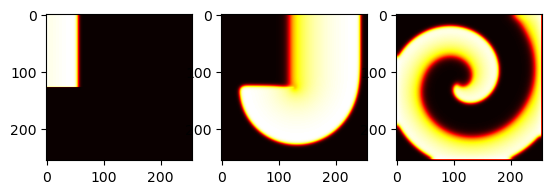

In [22]:

import matplotlib.pyplot as plt

import finitewave as fw


class UpdateMesh(fw.Command):
    """
    Update the mesh of the cardiac tissue during the simulation.
    """
    def __init__(self, time, updated_mesh):
        """
        Initialize the command with the time and the updated mesh.

        Args:
            time (int): The time at which the mesh is updated.
            updated_mesh (numpy.ndarray): The updated mesh.
        """
        super().__init__(time)
        self.updated_mesh = updated_mesh

    def execute(self, model):
        model.cardiac_tissue.mesh = self.updated_mesh
        model.compute_weights()


# set up the tissue:
n = 256
tissue = fw.CardiacTissue2D([n, n])
tissue.mesh[n//2, :n//2] = 2

mesh_without_block = tissue.mesh.copy()
mesh_without_block[n//2, :n//2] = 1

# set up stimulation parameters:
stim_sequence = fw.StimSequence()
stim_sequence.add_stim(fw.StimVoltageCoord2D(time=0, volt_value=1,
                                             x1=0, x2=n//2, y1=0, y2=5))
# stim_sequence.add_stim(fw.StimVoltageCoord2D(time=50, volt_value=1,
#                                              x1=n//2, x2=n, y1=0, y2=n))

command_sequence = fw.CommandSequence()
command_sequence.add_command(UpdateMesh(45, mesh_without_block))

# create model object:
model = fw.AlievPanfilov2D()
# set up numerical parameters:
model.dt = 0.01
model.dr = 0.3
model.t_max = 10

# add the tissue and the stim parameters to the model object:
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence
model.command_sequence = command_sequence

model.run()
u_10 = model.u.copy()

model.t_max = 46
model.run(initialize=False)
u_46 = model.u.copy()

model.t_max = 150
model.run(initialize=False)
u_150 = model.u.copy()


fig, axs = plt.subplots(ncols=3)
axs[0].imshow(u_10, cmap='hot')
axs[1].imshow(u_46, cmap='hot')
axs[2].imshow(u_150, cmap='hot')
plt.show()


### Two cross stimuls (S1S2)

This section demonstrates how to initiate a **spiral wave** in 2D cardiac tissue 
using a classical **cross-field S1–S2 stimulation** protocol.

The protocol applies two stimuli:
1. **S1**: a planar wave from one edge (top to bottom)
2. **S2**: a transverse wave from one side (left to right)

In [23]:

import matplotlib.pyplot as plt

import finitewave as fw

# set up the tissue:
n = 256
tissue = fw.CardiacTissue2D([n, n])


# set up stimulation parameters:
stim_sequence = fw.StimSequence()
stim_sequence.add_stim(fw.StimVoltageCoord2D(time=0, volt_value=1,
                                             x1=0, x2=n, y1=0, y2=5))
stim_sequence.add_stim(fw.StimVoltageCoord2D(time=50, volt_value=1,
                                             x1=n//2, x2=n, y1=0, y2=n))

# create model object:
model = fw.AlievPanfilov2D()
# set up numerical parameters:
model.dt = 0.01
model.dr = 0.3
model.t_max = 51
# add the tissue and the stim parameters to the model object:
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence

model.run()

u_s2 = model.u.copy() # save the model at the moment of the second stimulation

model.t_max = 200
model.run(initialize=False)

Running AlievPanfilov2D: 100%|█████████▉| 14900/14901 [00:03<00:00, 4153.31it/s]


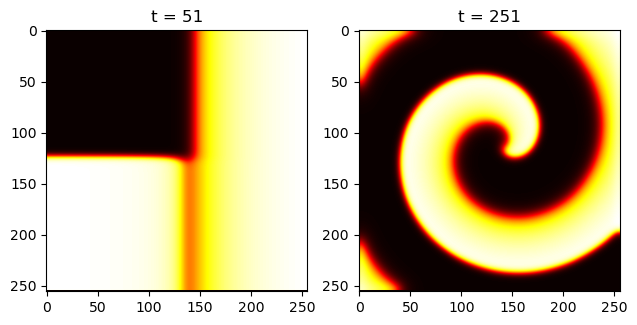

In [24]:
# show the spiral waves initiation (t = 51) and final stabilization (t = 251)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(u_s2, cmap='hot')
axs[0].set_title("t = 51")
axs[1].imshow(model.u, cmap='hot')
axs[1].set_title("t = 251")
plt.tight_layout()
plt.show()

### Equvidistant Stimulation
This section demonstrates **periodic stimulation** (paced activation) of 2D cardiac tissue with **diffuse fibrosis** that is finaly causing instability due to a high fibrosis density.
Here we use 35% randomly distributed **diffuse fibrosis** using `Diffuse2DPattern` - this introduces structural heterogeneity and **wavefront breakup**.


In [25]:

import numpy as np
np.random.seed(123) # for reproducibility 
import matplotlib.pyplot as plt

import finitewave as fw


# set up the tissue:
n = 256
tissue = fw.CardiacTissue2D([n, n])
tissue.add_pattern(fw.Diffuse2DPattern(0.35))

# set up stimulation parameters:
stim_sequence = fw.StimSequence()

# stimulate the tissue at the top border with a time step of 28:
for t in [0, 28, 56, 84]:
    stim_sequence.add_stim(fw.StimVoltageCoord2D(time=t, volt_value=1,
                                                x1=0, x2=n, y1=0, y2=5))

# create model object:
model = fw.AlievPanfilov2D()
# set up numerical parameters:
model.dt = 0.01
model.dr = 0.3
model.t_max = 100
# add the tissue and the stim parameters to the model object:
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence

model.run()
u_s2 = model.u.copy() # save the model during the fragmentation process

model.t_max = 300
model.run(initialize=False)

Running AlievPanfilov2D: 100%|██████████| 20000/20000 [00:03<00:00, 5326.11it/s]


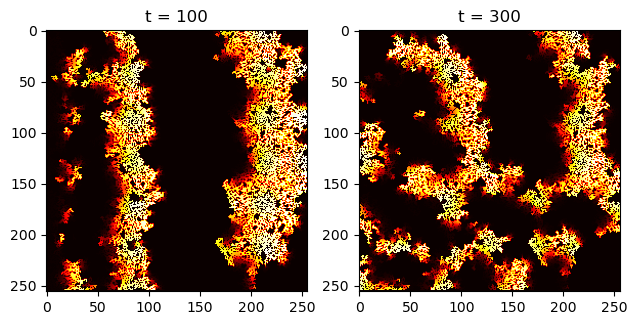

In [26]:
# show the wavefront fragmentation process t = 100) and the instability (t = 300) 
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(u_s2, cmap='hot')
axs[0].set_title("t = 100")
axs[1].imshow(model.u, cmap='hot')
axs[1].set_title("t = 300")
plt.tight_layout()
plt.show()

### S1S2 protocol with shorter S2

In this section we initiate a **spiral wave** with **26% diffuse fibrosis**. Here we also use 
**S1–S2 protocol**, where the final extrastimulus (S2) is delivered at a shorter coupling interval 
than the preceding regular pacing beats (S1).

In [27]:
np.random.seed(27)
import matplotlib.pyplot as plt
import finitewave as fw

# set up the tissue:
n = 256
tissue = fw.CardiacTissue2D([n, n])
tissue.add_pattern(fw.Diffuse2DPattern(0.26))

# set up stimulation parameters:
stim_sequence = fw.StimSequence()
# stimulate the tissue with a 2x45 prebeats, 3x30 s1 and 1x23 s2:
prebeats = np.array([0, 45])
s1 = prebeats[-1] + np.array([30, 2 * 30, 3 * 30])
s2 = s1[-1] + np.array([23])
for t in np.concatenate([prebeats, s1, s2]):
    stim_sequence.add_stim(fw.StimVoltageCoord2D(time=t, volt_value=1,
                                                 x1=0, x2=n, y1=0, y2=5))

# create model object:
model = fw.AlievPanfilov2D()
# set up numerical parameters:
model.dt = 0.01
model.dr = 0.3
model.t_max = s2[-1] + 2
# add the tissue and the stim parameters to the model object:
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence

model.run()
u_s2 = model.u.copy()

model.t_max = 400
model.run(initialize=False)

Running AlievPanfilov2D: 100%|█████████▉| 24000/24001 [00:04<00:00, 4842.59it/s]


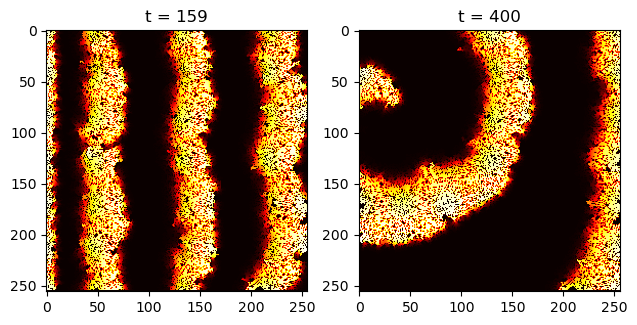

In [28]:
# show the wavefront sequence (t = 159) and the stable spiral wave (t = 400)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(u_s2, cmap='hot')
axs[0].set_title(f"t = {s2[-1] + 1}")
axs[1].imshow(model.u, cmap='hot')
axs[1].set_title("t = 400")
plt.tight_layout()
plt.show()
